In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from pandas import DataFrame
from pandas import concat
from scipy.stats import linregress as lr
from scipy.signal import find_peaks as find_peaks

In [3]:
patient = 1
cgmSeries = pd.read_csv("DataFolder/CGMDatenumLunchPat" + str(patient) + ".csv")
cgmData = pd.read_csv("DataFolder/CGMSeriesLunchPat" + str(patient) + ".csv")
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)
# cgmData.dropna()
insulinBasal = pd.read_csv("DataFolder/InsulinBasalLunchPat" + str(patient) + ".csv")
insulinBasal = insulinBasal.fillna(0)
insulinBolus = pd.read_csv("DataFolder/InsulinBolusLunchPat" + str(patient) + ".csv")
insulinBolus = insulinBolus.fillna(0)
insulinTime = pd.read_csv("DataFolder/InsulinDatenumLunchPat" + str(patient) + ".csv")
# print(insulinBasal.table)

In [4]:
reading_no = 1
# Normalize CGMValues
cgmValues_np = cgmData.values
cgmNorm_np = pre.minmax_scale(cgmValues_np, axis=1)

# CGM Timeseries
cgmSeries_np = cgmSeries.values
timeMins = np.nanmin(cgmSeries_np, axis=1)
cgmSeries_np = cgmSeries_np - timeMins[:, None]

# Normalize insulinBasal
insulinBasal_np = insulinBasal.values
insulinBasalNorm_np = pre.minmax_scale(insulinBasal_np, axis=1)

# Normalize insulinBolus
insulinBolus_np = insulinBolus.values
insulinBolusNorm_np = pre.minmax_scale(insulinBolus_np, axis=1)

# Insluin Timeseries
insulinTime_np = insulinTime.values - timeMins[:, None]

In [5]:
# Slope between max and min
maxs = np.argmax(cgmNorm_np, axis=1)
mins = [np.argmin(cgmNorm_np[i, maxs[i]:])+maxs[i] for i in range(len(maxs))]

slopes = []
time_diffs = []
for i in range(len(maxs)):
    slope = (cgmNorm_np[i][maxs[i]]-cgmNorm_np[i][mins[i]])/(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    time_diffs.append(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    slopes.append([slope])
    
slopes = np.nan_to_num(slopes)
time_diffs = np.nan_to_num(time_diffs)

/home/omkar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [6]:
# Regression Error
reg_window_size = 6
reg_errors = []
peak_values = []
peak_heights = []
peak_time_diffs = []
peak_times = []
for j in range(len(cgmNorm_np)):
    errors = np.array([])
    for i in range(len(cgmNorm_np[j])-reg_window_size):
        times = cgmSeries_np[j][i:i+reg_window_size-1]
        coeffs = np.polyfit(times, cgmNorm_np[j][i:i+reg_window_size-1], 1)
        poly = np.poly1d(coeffs)
        error = poly(cgmSeries_np[j][i+reg_window_size])-cgmNorm_np[j][i+reg_window_size];
        errors = np.append(errors, error)
    peaks, height_dict = find_peaks(errors, height = 0)
    heights = height_dict['peak_heights']
    sorted_args = heights.argsort()
    peaks = peaks[sorted_args]
    peaks = peaks[-2:]
    heights = heights[sorted_args]
    heights = heights[-2:]
    values = cgmNorm_np[j][peaks+reg_window_size-1]
    times = cgmSeries_np[j][peaks+reg_window_size]
    times2 = cgmSeries_np[j][peaks+reg_window_size-1]
    reg_errors.append(errors)
    peak_values.append(values)
    peak_heights.append(heights)
    peak_time_diffs.append(times)
    peak_times.append(times2)
reg_errors = np.array(reg_errors)

[11.52000007]
0.08680555503815413


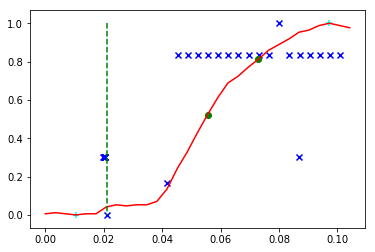

[0.81176471 0.52352941]
[0.03529412 0.09882353]
[0.07291667 0.05555555]


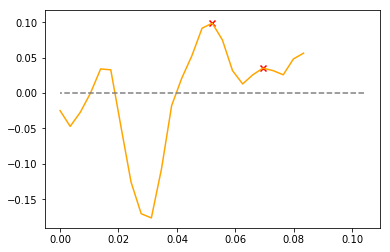

[20.57142862]
0.048611111007630825


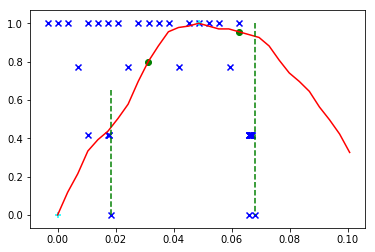

[0.95555556 0.8       ]
[0.09629631 0.15703703]
[0.0625  0.03125]


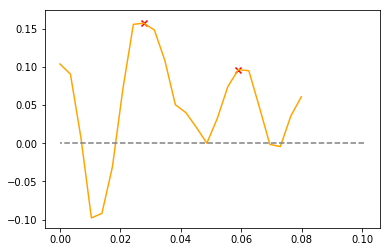

[13.71428568]
0.0729166668606922


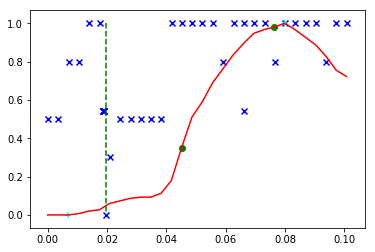

[0.98013245 0.35099338]
[0.1245033  0.16953644]
[0.07638889 0.04513889]


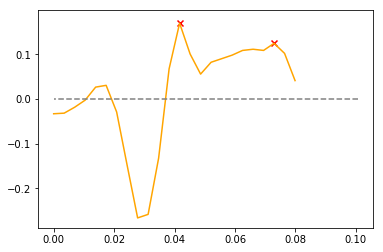

[13.09090905]
0.0763888891087845


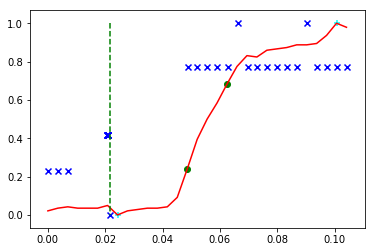

[0.23943662 0.68309859]
[0.11830988 0.16197184]
[0.04861111 0.0625    ]


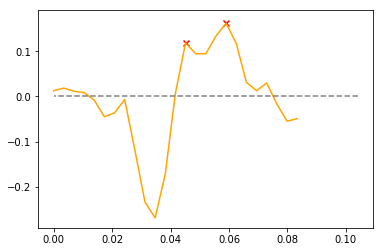

[32.]
0.03125


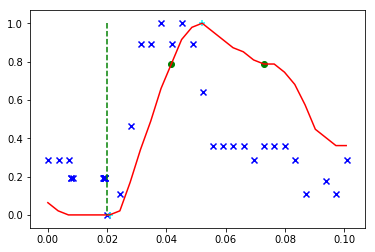

[0.78723404 0.78723404]
[0.17872342 0.30212766]
[0.07291667 0.04166667]


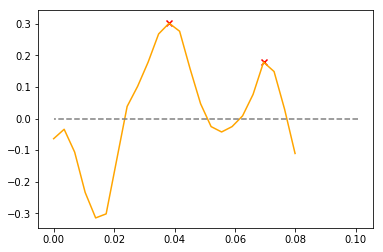

[15.15789457]
0.06597222294658422


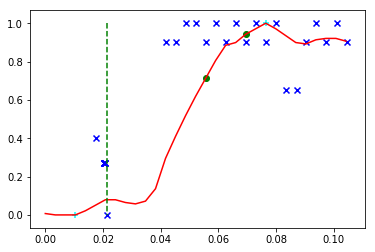

[0.71223022 0.94244604]
[0.12661871 0.13956834]
[0.05555555 0.06944444]


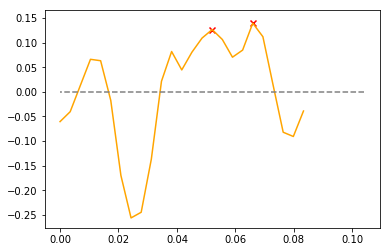

[32.]
0.03125


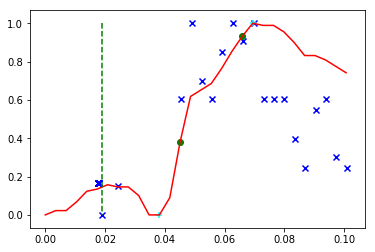

[0.93258427 0.38202247]
[0.20674158 0.39101125]
[0.0659838  0.04515046]


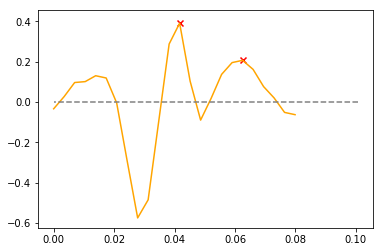

[13.71428563]
0.07291666709352285


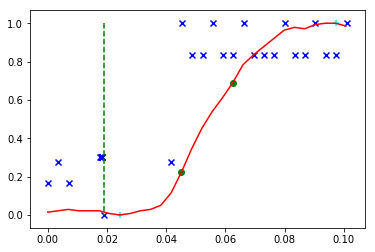

[0.22302158 0.69064748]
[0.07338132 0.08633094]
[0.04513889 0.0625    ]


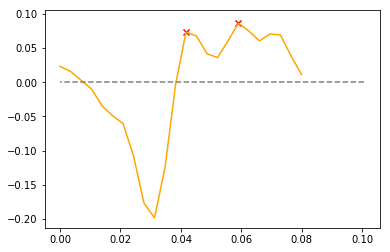

[10.66666667]
0.09375


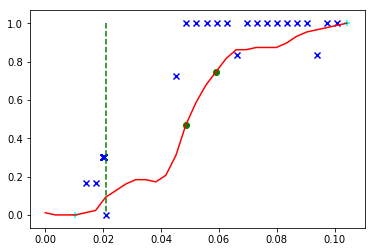

[0.74712644 0.47126437]
[0.12873563 0.15172416]
[0.05902778 0.04861111]


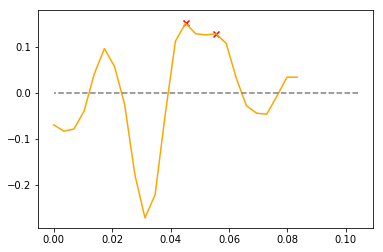

[19.18720837]
0.05211805598810315


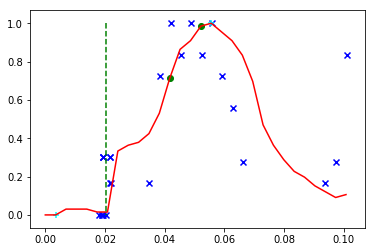

[0.98484848 0.71212121]
[0.26060606 0.30293396]
[0.05211806 0.04166667]


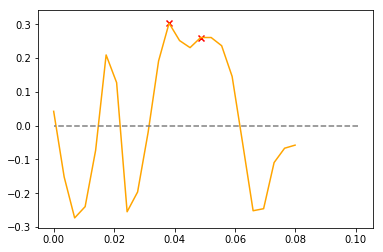

[16.94117641]
0.05902777798473835


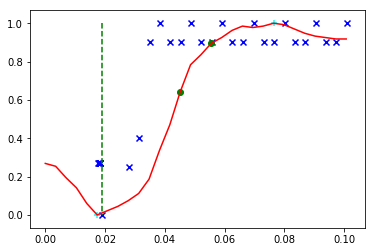

[0.89552239 0.64179104]
[0.07761194 0.23134328]
[0.05555556 0.04513889]


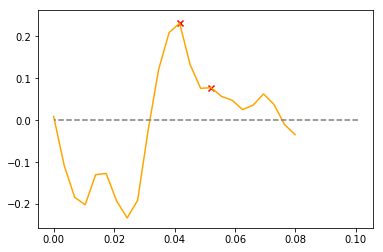

[16.]
0.0625


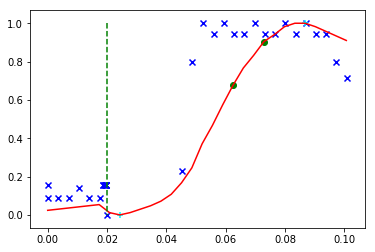

[0.67664671 0.90419162]
[0.09461077 0.10778443]
[0.0625     0.07291667]


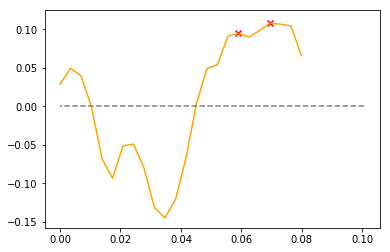

[16.]
0.0625


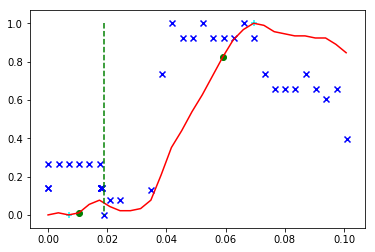

[0.01098901 0.82417582]
[0.09230769 0.19560439]
[0.01042824 0.05903935]


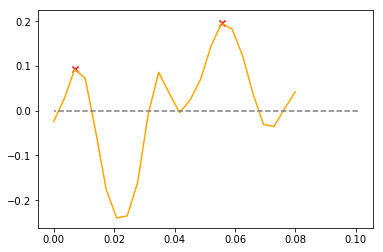

[18.00375097]
0.05554398091044277


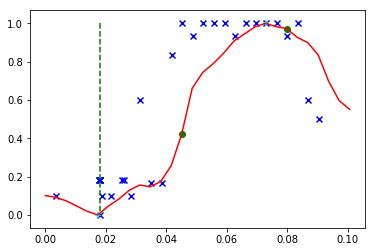

[0.97247706 0.42201835]
[0.15412842 0.29357798]
[0.07984954 0.04512731]


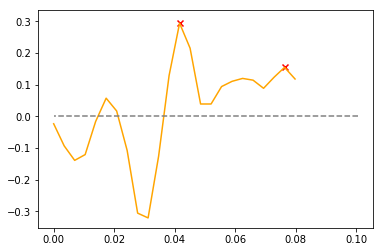

[10.66666667]
0.09375


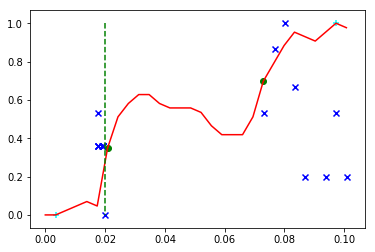

[0.69767442 0.34883721]
[0.26976745 0.46511627]
[0.07291667 0.02083333]


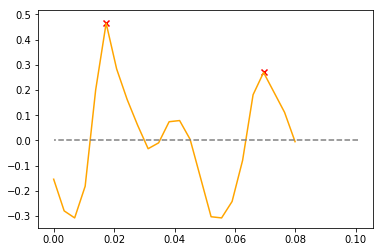

[14.40000006]
0.06944444414693862


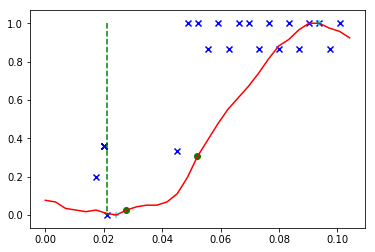

[0.02542373 0.30508475]
[0.00338983 0.06610168]
[0.02777778 0.05208333]


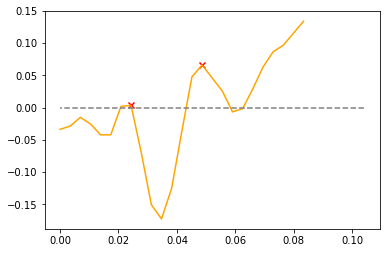

[26.18181839]
0.03819444414693862


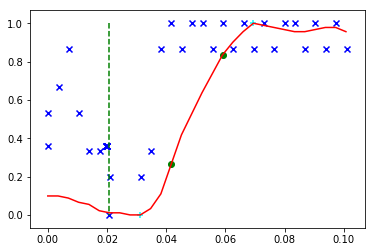

[0.26373626 0.83516484]
[0.10329669 0.15384615]
[0.04166667 0.05902778]


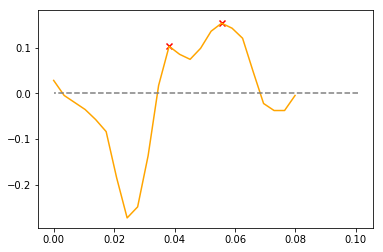

[10.0000002]
0.020833332906477153


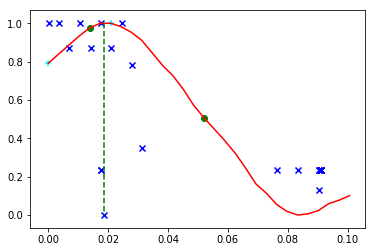

[0.50595238 0.97619048]
[0.02619046 0.125     ]
[0.05208333 0.01388889]


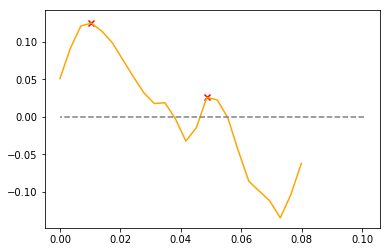

[12.52173898]
0.07986111205536872


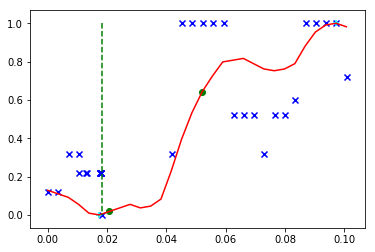

[0.01834862 0.64220183]
[0.01834862 0.19633028]
[0.02083333 0.05208333]


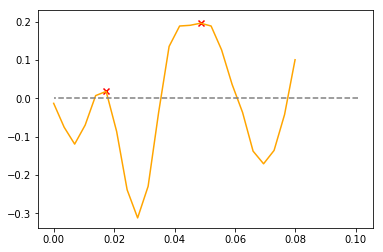

[13.71428566]
0.07291666697710752


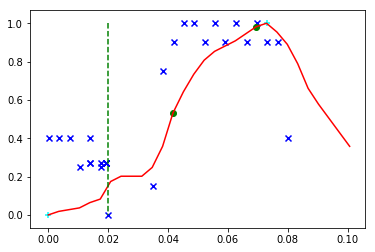

[0.53211009 0.98165138]
[0.18715598 0.25137616]
[0.04166667 0.06944444]


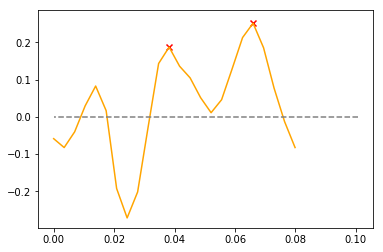

[15.15523599]
0.06598379602655768


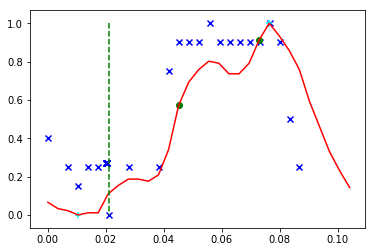

[0.57142857 0.91208791]
[0.36702349 0.43296705]
[0.04513889 0.07292824]


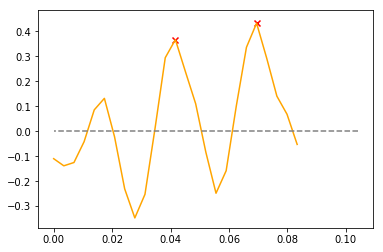

[0.]
0.0


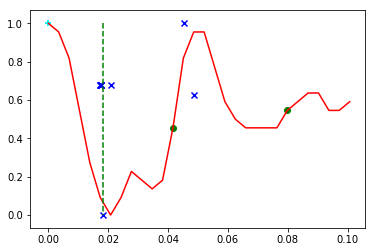

[0.54545455 0.45454545]
[0.20909091 0.89090911]
[0.07988426 0.04166667]


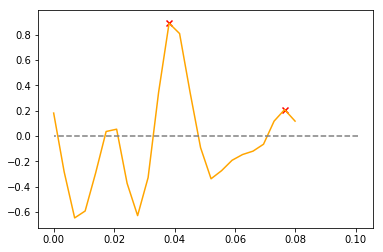

[18.00000017]
0.055555555038154125


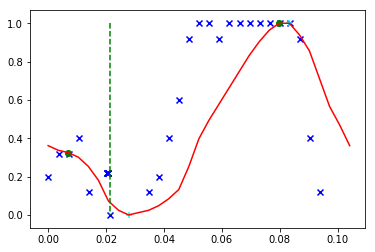

[0.3253012 1.       ]
[0.12289157 0.28915663]
[0.00694444 0.07986111]


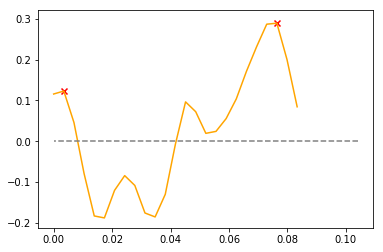

[18.00000017]
0.055555555038154125


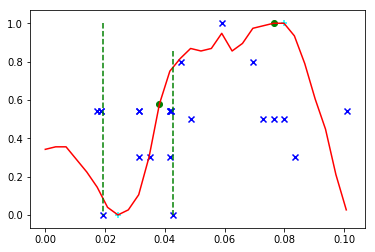

[1.         0.57894737]
[0.34210523 0.41842105]
[0.07638889 0.03819444]


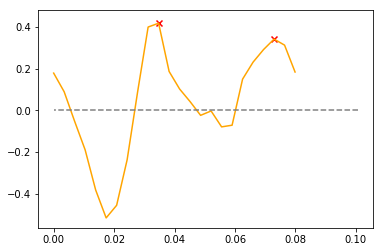

[16.]
0.0625


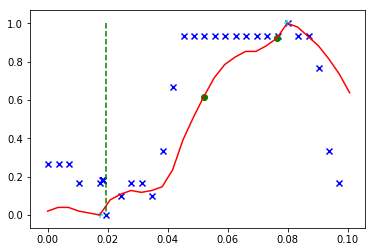

[0.61764706 0.92156863]
[0.15882354 0.22745099]
[0.05208333 0.07638889]


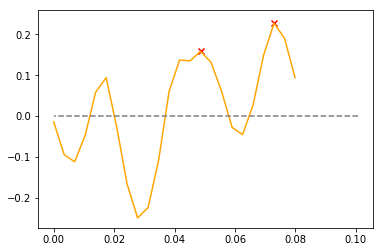

[20.57142857]
0.04861111112404615


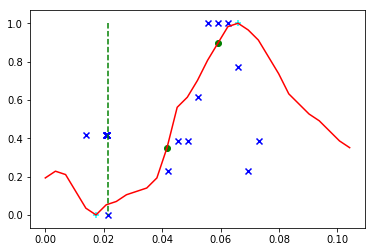

[0.35087719 0.89473684]
[0.17894736 0.29122808]
[0.04166667 0.05902778]


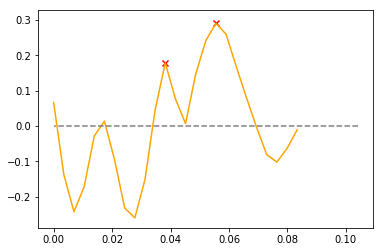

[0.]
0.0


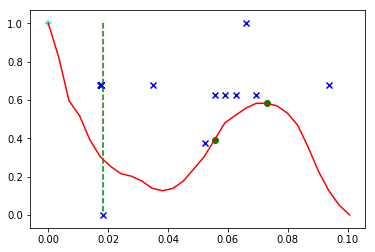

[0.39240506 0.58227848]
[0.13417721 0.19240507]
[0.05555556 0.07291667]


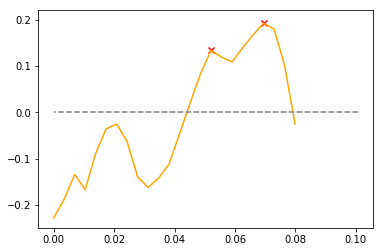

[0.]
0.0


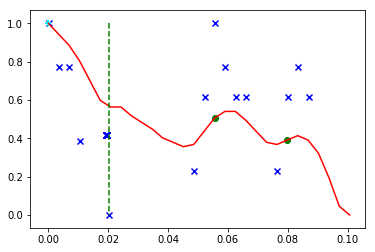

[0.50574713 0.3908046 ]
[0.21149425 0.27816095]
[0.05555556 0.07986111]


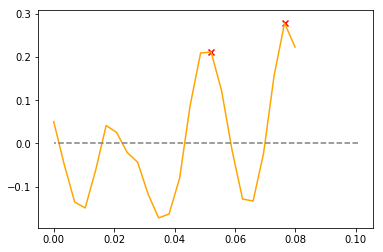

[11.99999991]
0.08333333395421505


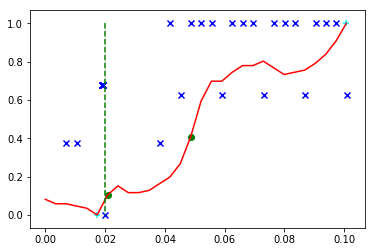

[0.10465116 0.40697674]
[0.12093023 0.26744185]
[0.02083333 0.04861111]


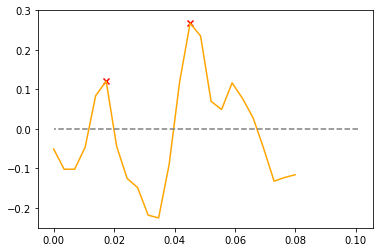

[0.]
0.0


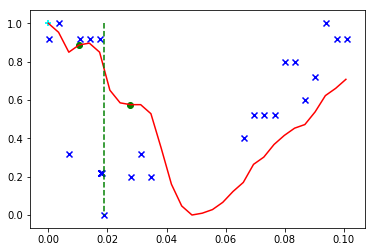

[0.88679245 0.5754717 ]
[0.22452829 0.31698112]
[0.01041667 0.02777778]


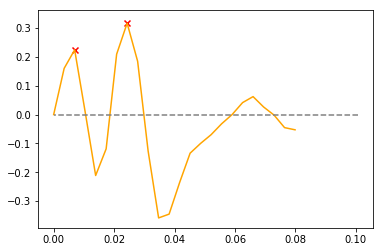

[32.76190562]
0.024305554921738803


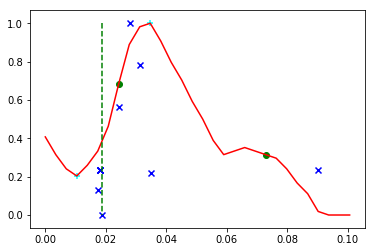

[0.31481481 0.68518519]
[0.10740741 0.55555557]
[0.07291667 0.02430556]


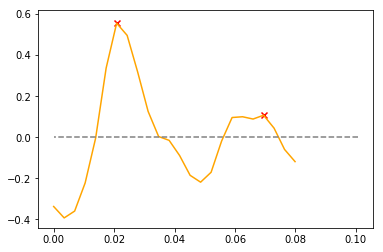

[16.93453572]
0.05905092507600784


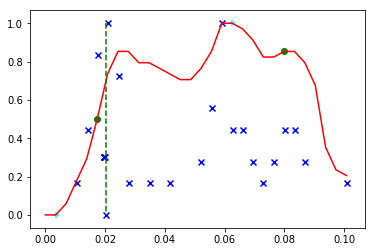

[0.85294118 0.5       ]
[0.42941178 0.4882353 ]
[0.07988426 0.01736111]


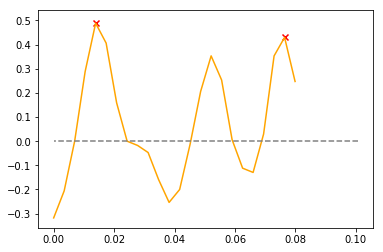

[16.]
0.0625


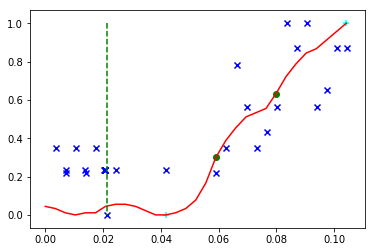

[0.63333333 0.3       ]
[0.08888888 0.15777778]
[0.07986111 0.05902778]


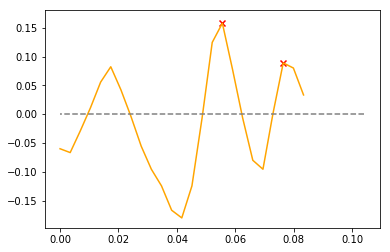

In [7]:
# Anirudh Features
for i in range(0, len(cgmSeries_np)):
    print(slopes[i])
    print(time_diffs[i])
    plt.figure()
    plt.plot(cgmSeries_np[i], cgmNorm_np[i], c='red')
    plt.scatter(insulinTime_np[i], insulinBasalNorm_np[i], marker='x', c='blue')
    plt.scatter(peak_times[i], peak_values[i], marker='o', c='green')
    plt.scatter(cgmSeries_np[i][maxs[i]], cgmNorm_np[i][maxs[i]], marker='+', c='cyan')
    plt.scatter(cgmSeries_np[i][mins[i]], cgmNorm_np[i][mins[i]], marker='+', c='cyan')
    insulinBolusNon = insulinBolusNorm_np[i]
    insulinTimesNon = insulinTime_np[i]
    insulinTimesNon = insulinTimesNon[np.nonzero(insulinBolusNon)]
    insulinBolusNon = insulinBolusNon[np.nonzero(insulinBolusNon)]
    for j in range(0, len(insulinBolusNon)):
        plt.plot([insulinTimesNon[j], insulinTimesNon[j]], [insulinBolusNon[j], 0], c='green', linestyle='dashed')
    plt.show()
#     plt.figure()
#     plt.plot(cgmSeries_np[i][:-window_size], vels[i], c='blue')
#     plt.plot(cgmSeries_np[i], np.zeros(len(cgmSeries_np[i])), c='gray', linestyle='dashed')
#     plt.show()
#     plt.figure()
#     plt.plot(cgmSeries_np[i][:-2*window_size], accs[i], c='pink')
#     plt.show()
    print(peak_values[i])
    print(peak_heights[i])
    print(peak_times[i])
    plt.figure()
    plt.plot(cgmSeries_np[i][reg_window_size:], reg_errors[i], c='orange')
    plt.plot(cgmSeries_np[i], np.zeros(len(cgmSeries_np[i])), c='gray', linestyle='dashed')
    plt.scatter(peak_time_diffs[i], peak_heights[i], c='red', marker='x')
    plt.show()    

In [8]:
# Windowed features
window_mins = []
window_maxs = []
window_means = []
window_vars = []
for i in range(0, len(cgmSeries_np)):
    window_input = DataFrame(cgmNorm_np[i][::-1])
    width=5
    shifted=window_input.shift(width - 1)
    window=shifted.rolling(window=width)
    dataframe=concat([window.var(), window.min(),  window.mean(), window.max() ], axis=1)
    dataframe.columns = ['var', 'min', 'mean', 'max']
    window_features = dataframe.nlargest(2,'var')
    window_values = window_features.values
    window_mins.append([window_values[0][1], window_values[1][1]])
    window_maxs.append([window_values[0][3], window_values[1][3]])
    window_vars.append([window_values[0][0], window_values[1][0]])
    window_means.append([window_values[0][2], window_values[1][2]])
#     print(window_values)
#     print(window_features)
# print(window_mins)

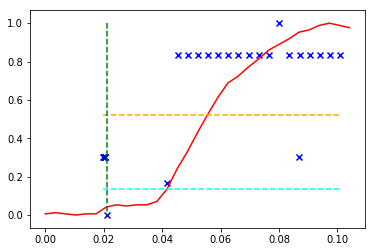

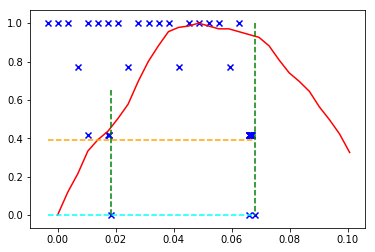

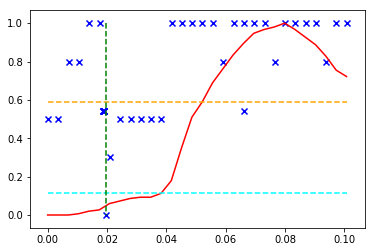

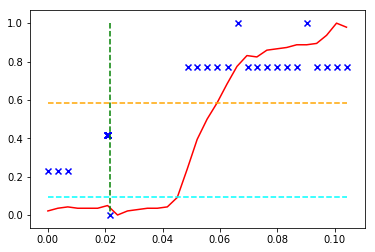

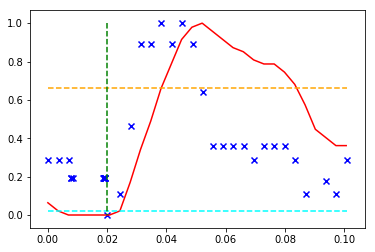

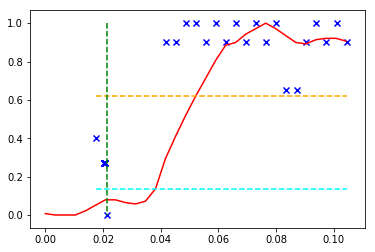

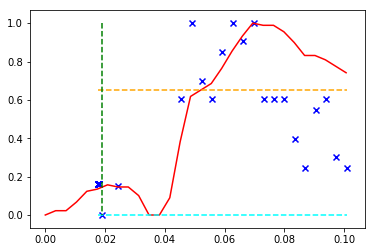

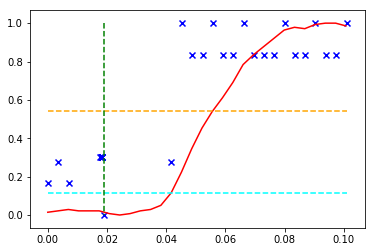

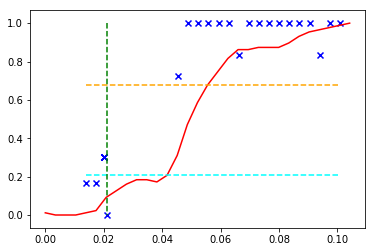

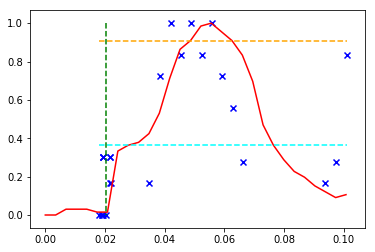

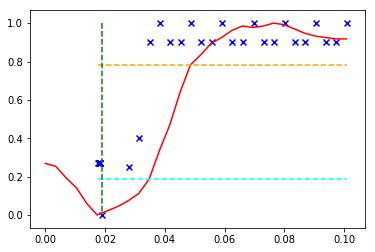

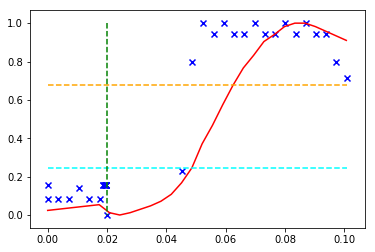

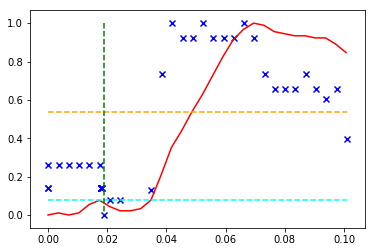

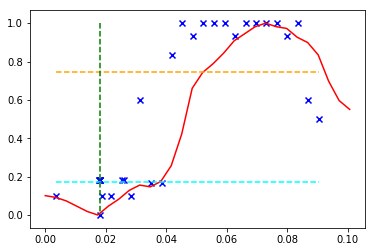

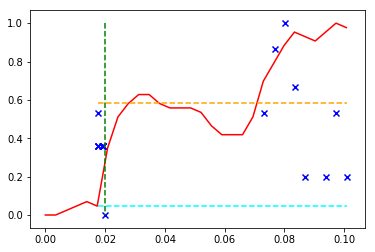

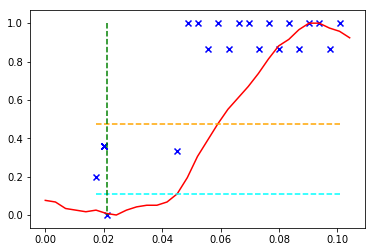

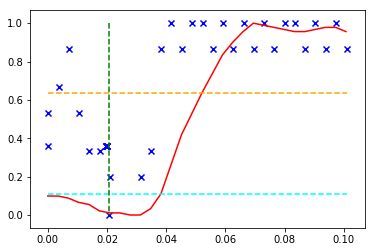

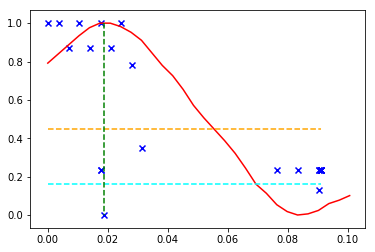

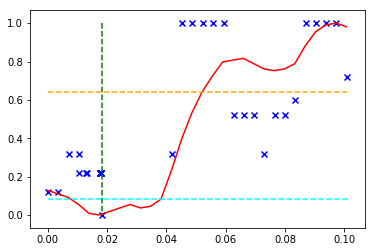

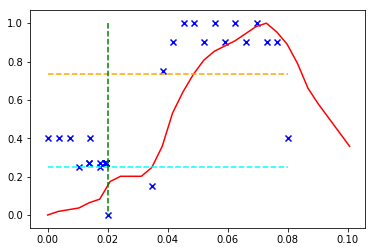

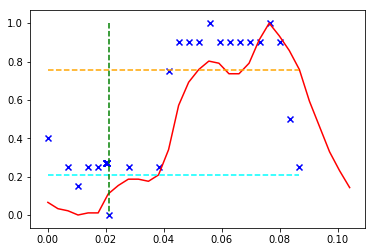

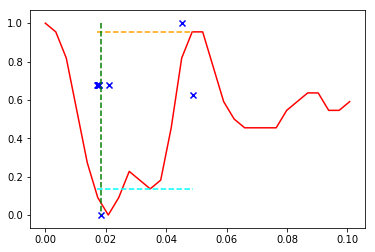

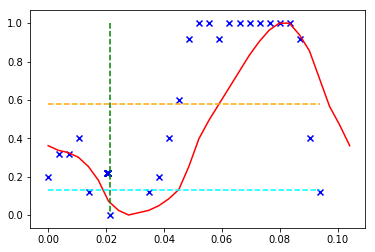

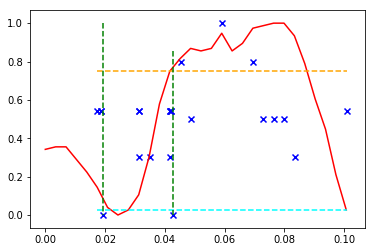

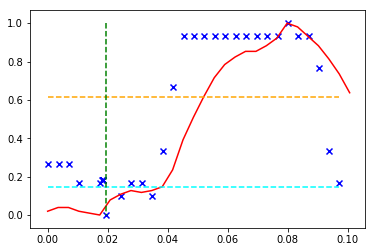

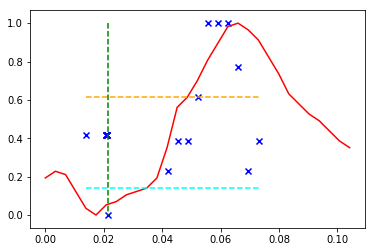

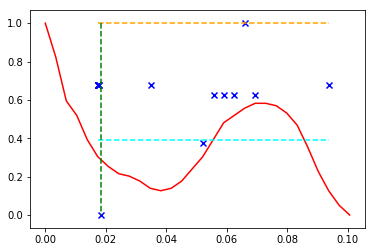

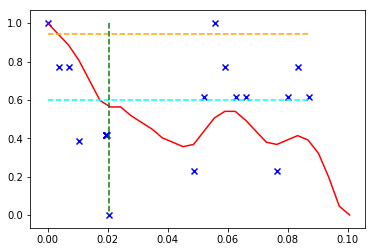

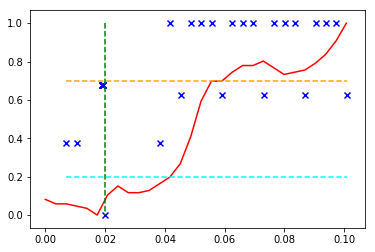

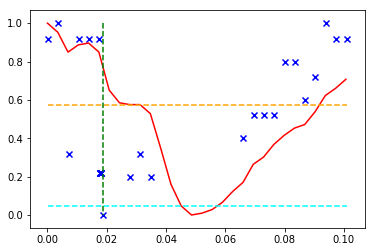

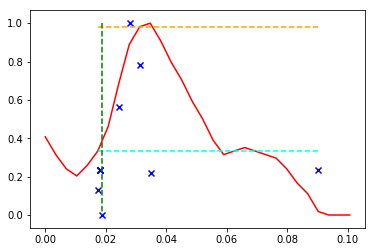

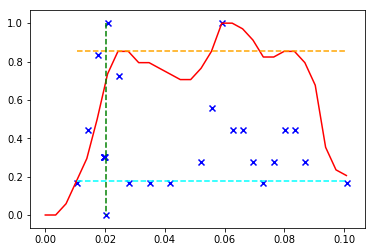

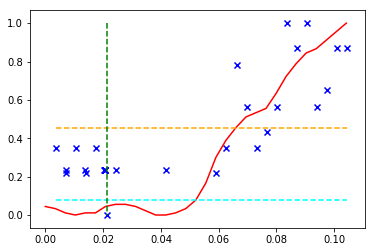

In [9]:
# Vedant Features
for i in range(0, len(cgmSeries_np)):
    plt.figure()
    plt.plot(cgmSeries_np[i], cgmNorm_np[i], c='red')
    plt.scatter(insulinTime_np[i], insulinBasalNorm_np[i], marker='x', c='blue')
    po1 = np.nanmin(insulinTime_np[i])
    po2 = np.nanmax(insulinTime_np[i])
    plt.plot([po1, po2], [window_mins[i][0], window_mins[i][0]], c='cyan', linestyle='dashed')
    plt.plot([po1, po2], [window_maxs[i][0], window_maxs[i][0]], c='orange', linestyle='dashed')
    insulinBolusNon = insulinBolusNorm_np[i]
    insulinTimesNon = insulinTime_np[i]
    insulinTimesNon = insulinTimesNon[np.nonzero(insulinBolusNon)]
    insulinBolusNon = insulinBolusNon[np.nonzero(insulinBolusNon)]
    for j in range(0, len(insulinBolusNon)):
        plt.plot([insulinTimesNon[j], insulinTimesNon[j]], [insulinBolusNon[j], 0], c='green', linestyle='dashed')
    plt.show()

In [10]:
series = np.asarray(cgmData)
datenum = np.asarray(cgmSeries)
InsulinBolus = np.asarray(insulinBolus)
InsulinTimestamp = np.asarray(insulinTime)

In [11]:
maximum=[]
InsulinBolusprev = InsulinBolus
for i in range(InsulinBolus[:,0].size):
    maximum.append(np.nanargmax(InsulinBolus[i]))
#maximum = InsulinBolus.argmax(axis=1)
#InsulinTimestamp[0,27]
print(maximum)
#print(indices)
# for i in range(length(maximum)):
#     print(InsulinTimestamp[i,maximum[i]])





[7, 37, 13, 11, 14, 8, 10, 10, 9, 7, 8, 17, 15, 7, 11, 8, 14, 8, 14, 16, 12, 7, 12, 3, 12, 8, 7, 12, 9, 14, 5, 7, 14]


In [12]:
def slope(time,values):
    slope = []
    for i in range(len(values)-1):
        slope.append((values[i+1]-values[i])/(time[i+1]-time[i])) 
    slope.append(np.nan)
    slope = np.asarray(slope)
    
    return slope
        

[92.08333333333334]


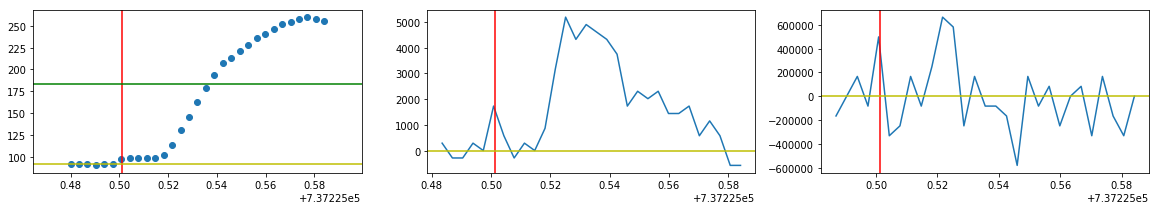

/home/omkar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


[92.08333333333334, nan]


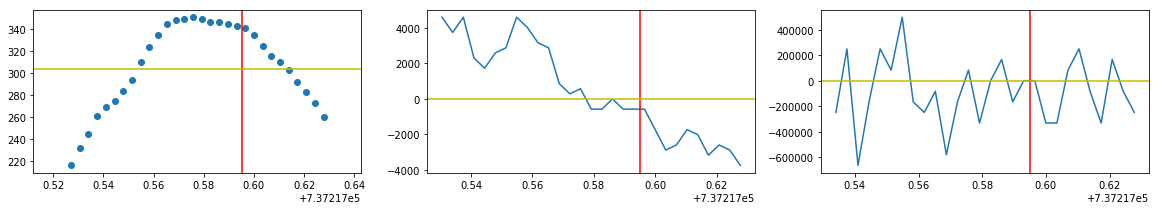

[92.08333333333334, nan, 104.80555555555554]


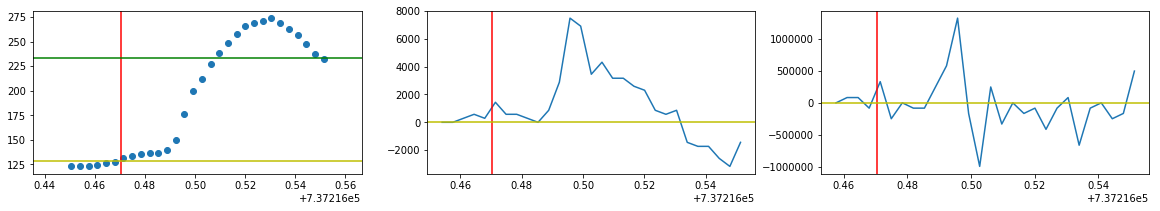

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001]


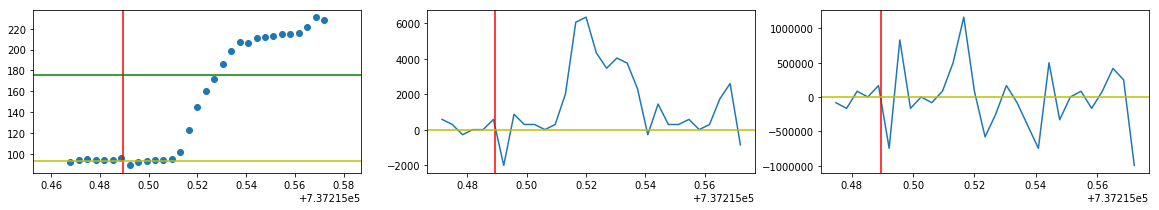

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304]


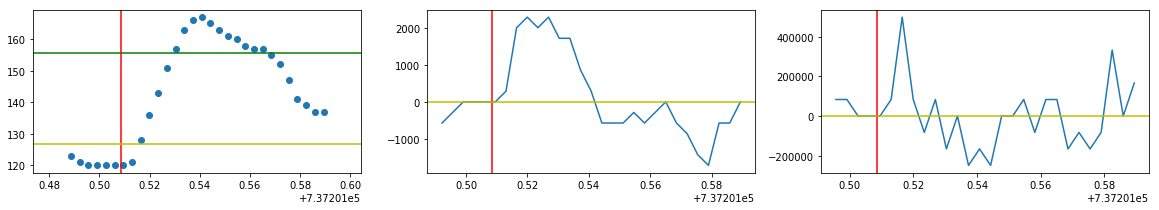

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111]


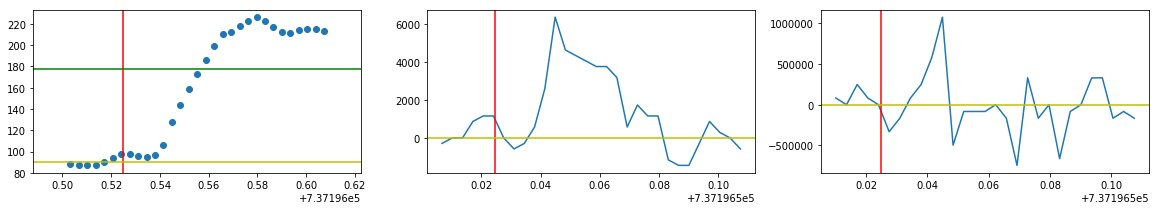

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571]


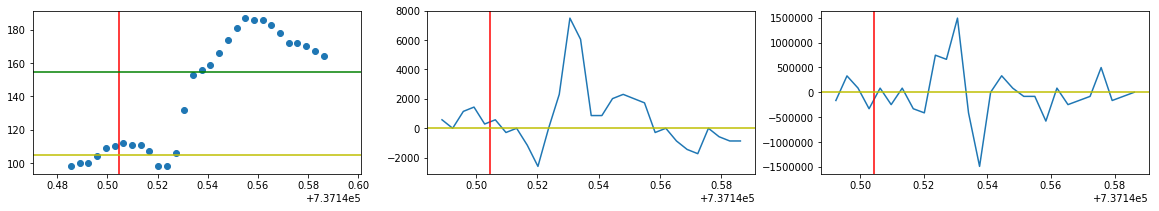

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381]


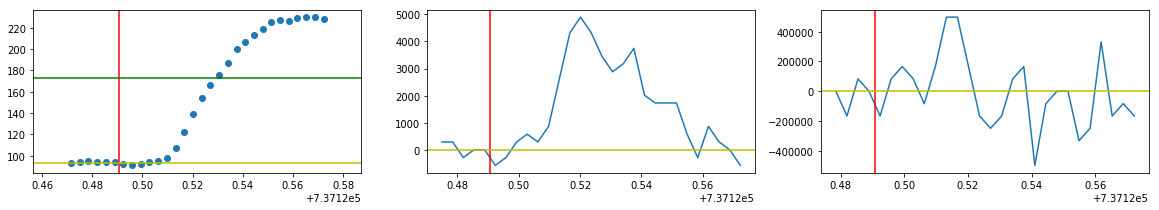

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626]


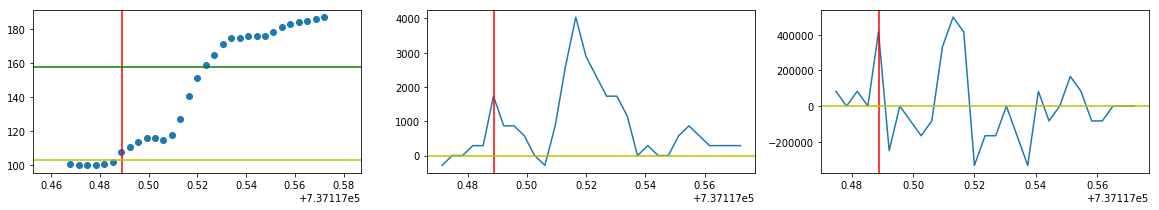

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657]


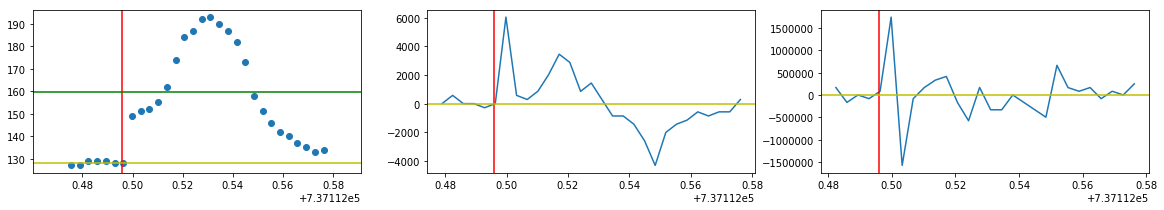

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648]


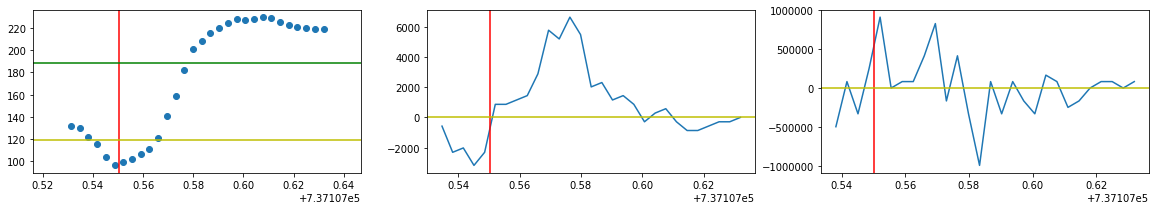

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286]


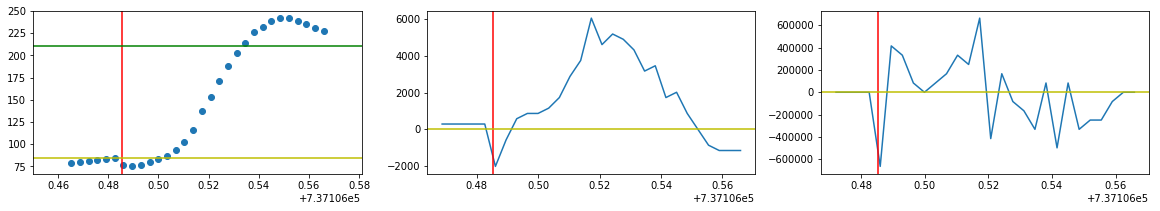

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857]


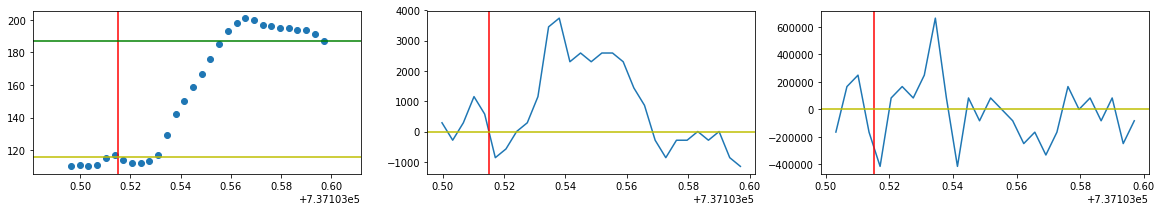

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014]


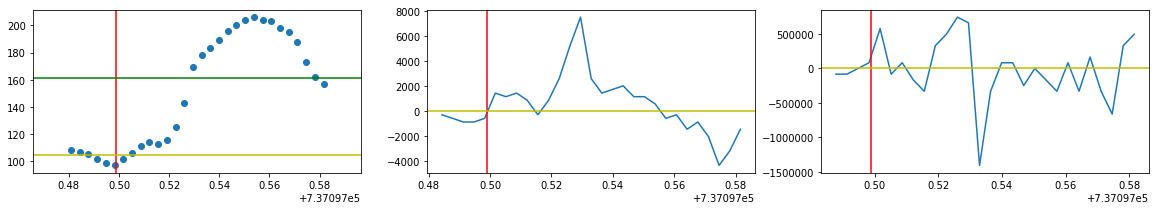

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997]


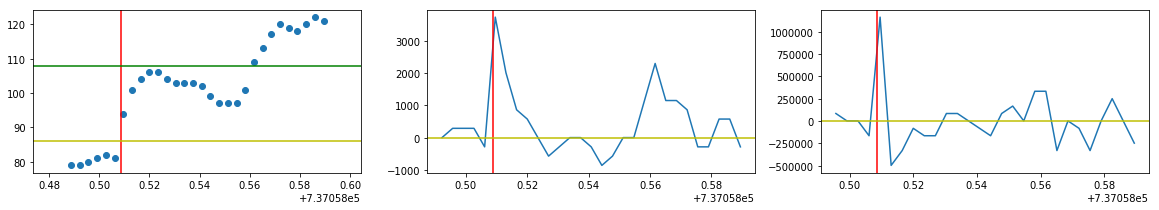

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093]


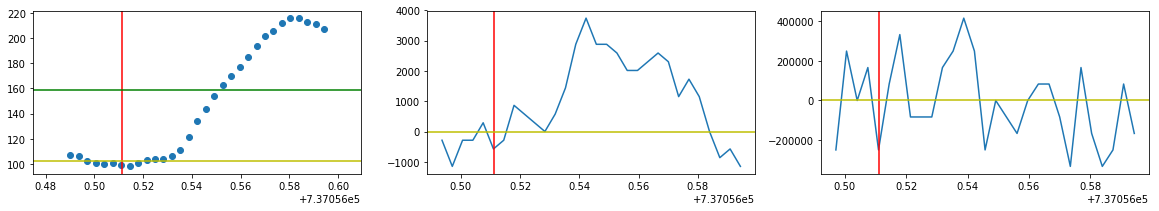

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146]


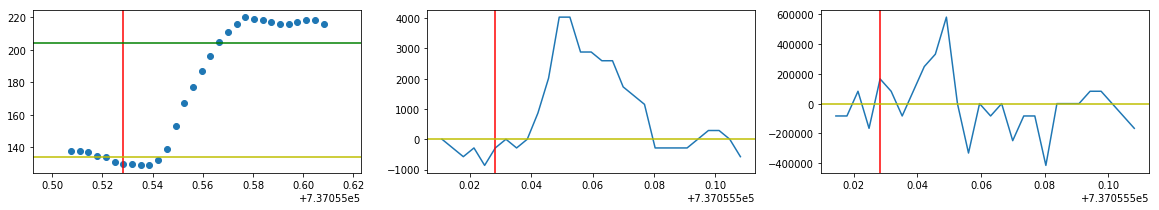

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146, -77.41614906832297]


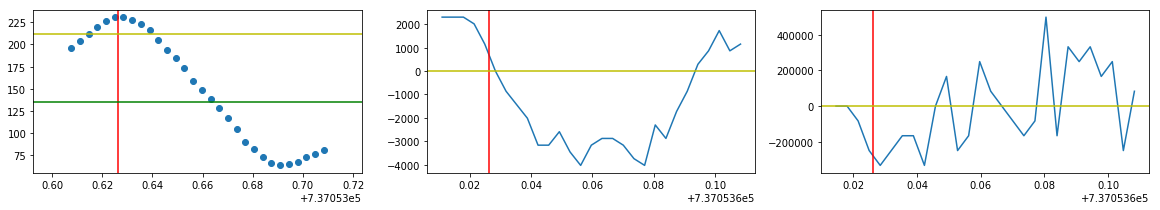

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146, -77.41614906832297, 74.24886877828054]


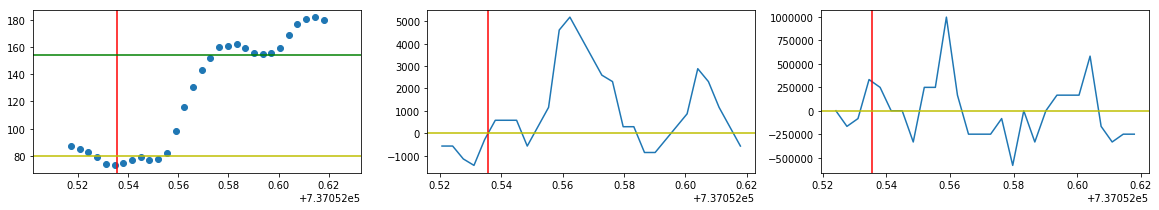

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146, -77.41614906832297, 74.24886877828054, 66.33333333333333]


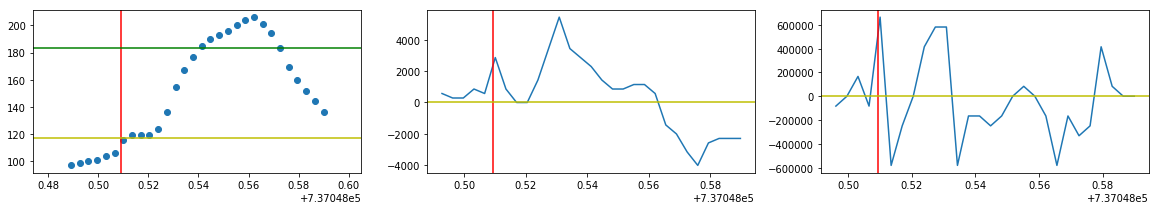

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146, -77.41614906832297, 74.24886877828054, 66.33333333333333, 51.985645933014354]


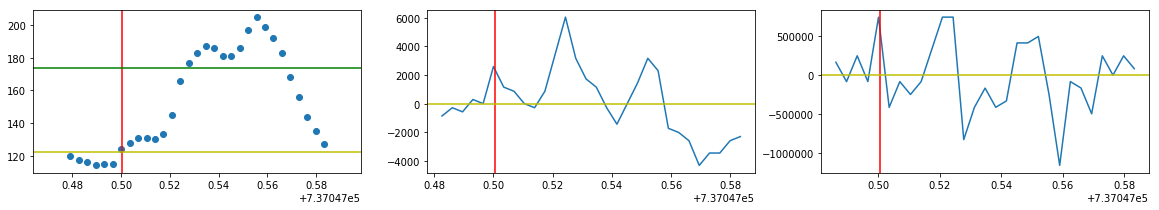

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146, -77.41614906832297, 74.24886877828054, 66.33333333333333, 51.985645933014354, -6.5]


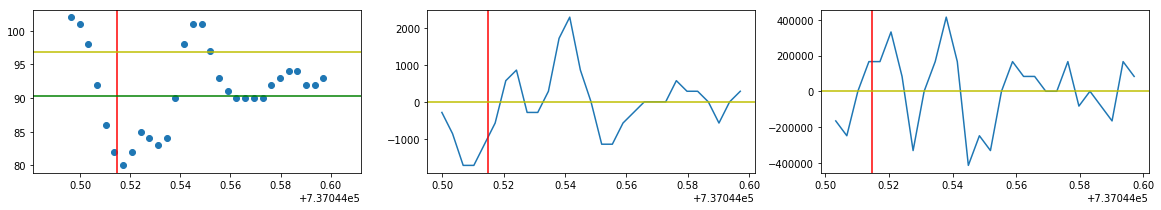

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146, -77.41614906832297, 74.24886877828054, 66.33333333333333, 51.985645933014354, -6.5, 36.56937799043061]


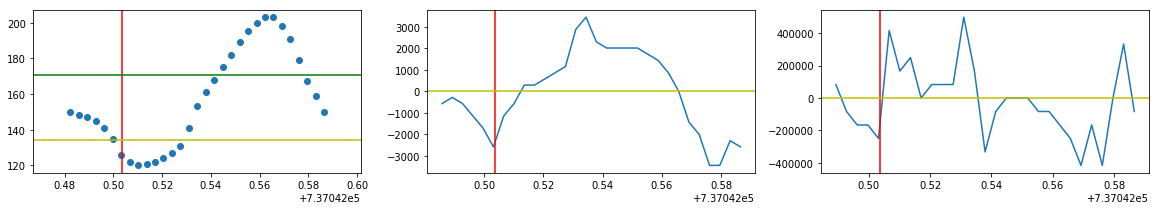

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146, -77.41614906832297, 74.24886877828054, 66.33333333333333, 51.985645933014354, -6.5, 36.56937799043061, 18.035714285714292]


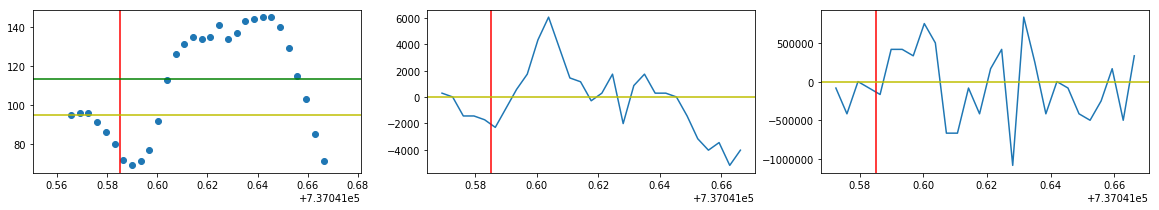

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146, -77.41614906832297, 74.24886877828054, 66.33333333333333, 51.985645933014354, -6.5, 36.56937799043061, 18.035714285714292, 65.5311004784689]


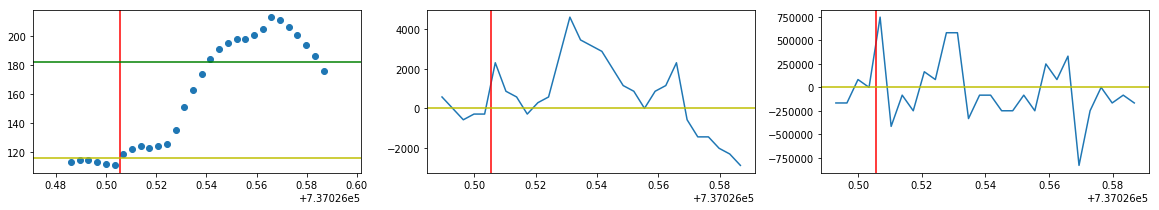

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146, -77.41614906832297, 74.24886877828054, 66.33333333333333, 51.985645933014354, -6.5, 36.56937799043061, 18.035714285714292, 65.5311004784689, 25.447204968944092]


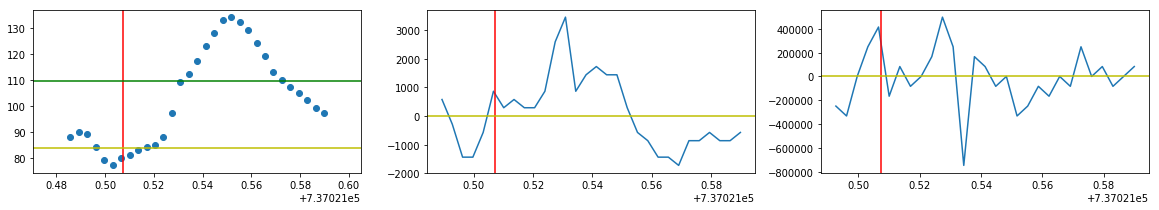

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146, -77.41614906832297, 74.24886877828054, 66.33333333333333, 51.985645933014354, -6.5, 36.56937799043061, 18.035714285714292, 65.5311004784689, 25.447204968944092, -31.58333333333333]


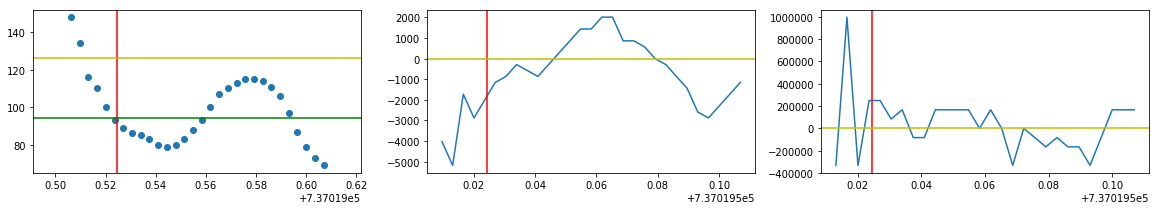

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146, -77.41614906832297, 74.24886877828054, 66.33333333333333, 51.985645933014354, -6.5, 36.56937799043061, 18.035714285714292, 65.5311004784689, 25.447204968944092, -31.58333333333333, -29.77990430622009]


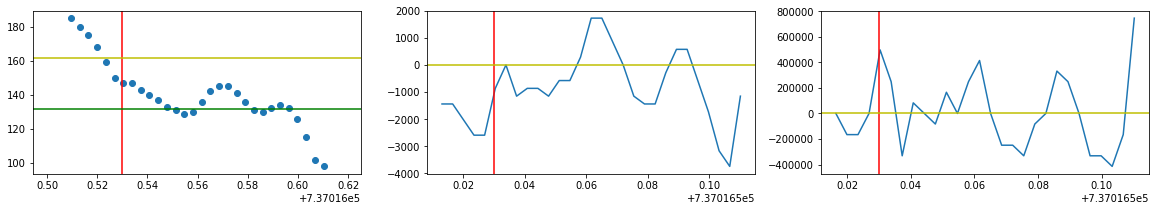

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146, -77.41614906832297, 74.24886877828054, 66.33333333333333, 51.985645933014354, -6.5, 36.56937799043061, 18.035714285714292, 65.5311004784689, 25.447204968944092, -31.58333333333333, -29.77990430622009, 42.59090909090909]


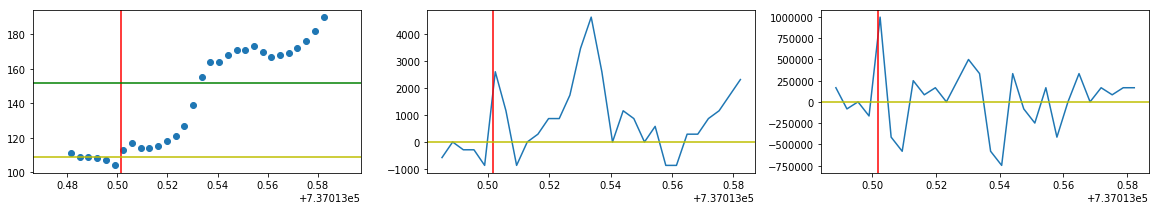

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146, -77.41614906832297, 74.24886877828054, 66.33333333333333, 51.985645933014354, -6.5, 36.56937799043061, 18.035714285714292, 65.5311004784689, 25.447204968944092, -31.58333333333333, -29.77990430622009, 42.59090909090909, -49.78280542986424]


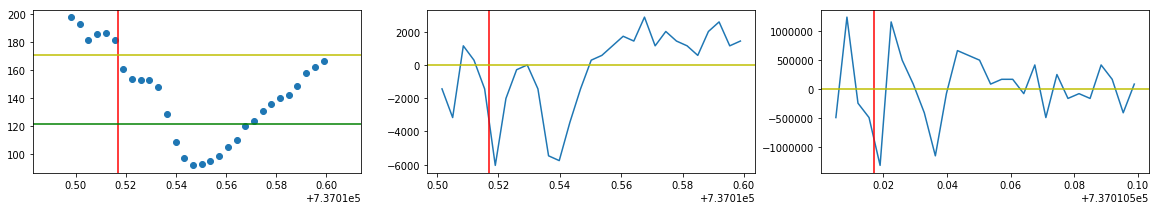

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146, -77.41614906832297, 74.24886877828054, 66.33333333333333, 51.985645933014354, -6.5, 36.56937799043061, 18.035714285714292, 65.5311004784689, 25.447204968944092, -31.58333333333333, -29.77990430622009, 42.59090909090909, -49.78280542986424, 4.730769230769226]


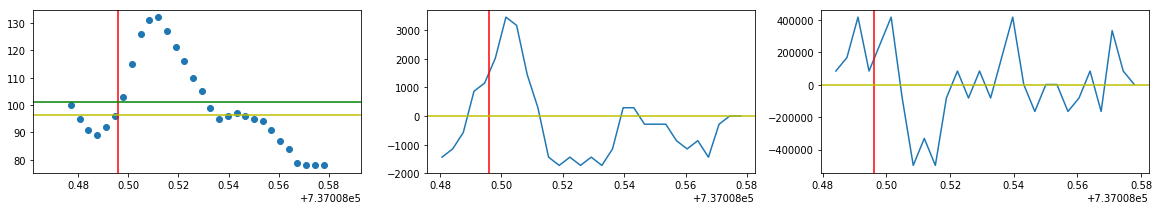

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146, -77.41614906832297, 74.24886877828054, 66.33333333333333, 51.985645933014354, -6.5, 36.56937799043061, 18.035714285714292, 65.5311004784689, 25.447204968944092, -31.58333333333333, -29.77990430622009, 42.59090909090909, -49.78280542986424, 4.730769230769226, 23.0]


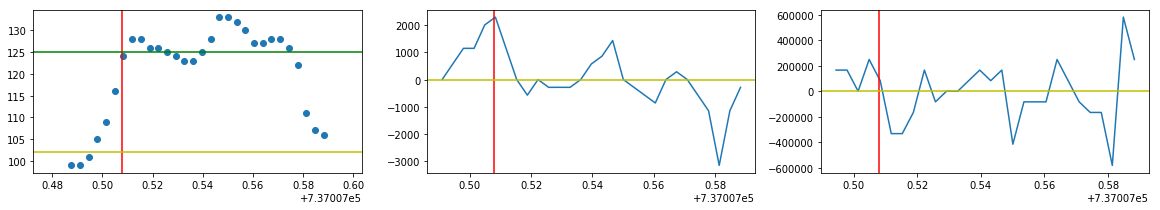

[92.08333333333334, nan, 104.80555555555554, 82.60000000000001, 28.97285067873304, 87.03105590062111, 49.71428571428571, 79.80952380952381, 54.761363636363626, 31.541666666666657, 70.06832298136648, 125.91964285714286, 71.00892857142857, 56.625000000000014, 21.799999999999997, 56.19254658385093, 70.33031674208146, -77.41614906832297, 74.24886877828054, 66.33333333333333, 51.985645933014354, -6.5, 36.56937799043061, 18.035714285714292, 65.5311004784689, 25.447204968944092, -31.58333333333333, -29.77990430622009, 42.59090909090909, -49.78280542986424, 4.730769230769226, 23.0, 44.04524886877829]


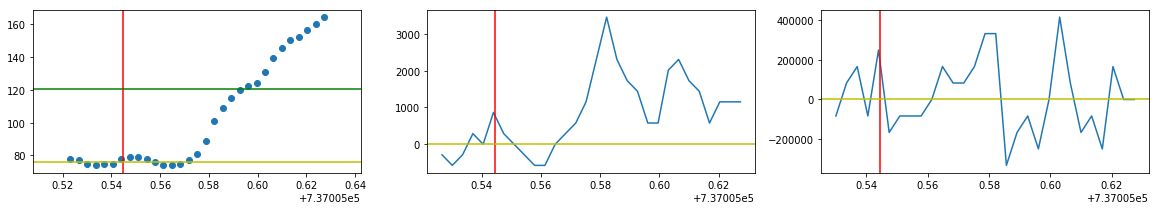

In [14]:
mean_before = []
mean_after = []
for i in range(0,33):
    fig = plt.figure(figsize=(20,3))
    
    #np.interp(series[i], (series[i].min(), series[i].max()), (-1, +1))
    sl = slope(datenum[i],series[i])
    
    
    sl_1 = slope(datenum[i],sl)
    sl_2 = slope(datenum[i],sl_1)
    sl_3 = slope(datenum[i],sl_2)
    #sl[]('NaN')
    #print(sl)
    #np.interp(sl, (sl.min(), sl.max()), (-1, +1))
    
#     summ = np.zeros
    #summ = summ + np.asarray(series[i])
#     summ = np.sum(summ,np.asarray(series[i]))
    cut = InsulinTimestamp[i,maximum[i]]
    #print(cut)
    cut1 = np.where(InsulinTimestamp[i]== cut)
    #cut1 = series[i][cut1]
    #print (series[i][-1:-int(cut1[0]):-1])
    mean1 = np.nanmean(series[i][-1:-int(cut1[0]):-1])
    #print(mean1)
    mean2 = np.nanmean(series[i][-int(cut1[0]):0:-1])
    #print(series[i][-int(cut1[0]):0:-1])
    #print(mean2)
    
    mean_before.append(mean1)
    mean_after.append(mean2)
    
    
    mean_dif = [x - y for x, y in zip(mean_after, mean_before)]
    print(mean_dif)
    
    
    plt.subplot(1,3,1)
    plt.scatter(datenum[i],series[i])
    plt.axvline(x=InsulinTimestamp[i,maximum[i]],c='r')
    plt.axhline(y = mean1,c='y')
    plt.axhline(y = mean2,c='g')
    
    plt.subplot(1,3,2)
    plt.plot(datenum[i],sl)
    plt.axvline(x=InsulinTimestamp[i,maximum[i]],c='r')
    plt.axhline(y = 0,c='y')
    
    plt.subplot(1,3,3)
    plt.plot(datenum[i],sl_1)
    plt.axvline(x=InsulinTimestamp[i,maximum[i]],c='r')
    plt.axhline(y = 0,c='y')
    
    plt.show()